# Results of trying out diff algorithms and finding nmi-best one

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn.datasets import fetch_mldata
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
import sklearn.neighbors as neigh_search
import scipy.sparse as sps
from consensus_clustering.load_data import load_fuzzy_data
from consensus_clustering import consensus
from consensus_clustering.lib import distance as cl_dist
from consensus_clustering.lib import density
from consensus_clustering.lib import similarity
import sys
# from scipy.spatial import distance
# from copy import deepcopy
# from timeit import default_timer as timer
# from datetime import timedelta
import importlib
%matplotlib inline

In [37]:
def old_plot_synth_cons_par(X, labels_cons,labels_par, figsize=(16,6), savetitle = None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=figsize)
    
    #consensus
    ax1=plt.subplot(1, 2, 1)
    ax1.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_cons[i]),s=74,alpha=0.2)

    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Consensus Clustering')   
    #parametersearch
    ax2=plt.subplot(1, 2, 2)
    ax2.axis('off')
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=plt.cm.Set2(labels_par[i]),s=74,alpha=0.2)
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.title('Highest NMI with Consensus Clustering')
    
    if savetitle:
        plt.savefig(savetitle, transparent = True)

In [38]:
def plot_synth_cons_par(X, labels_cons, labels_nmi, labels_anmi, figsize=(16,6), savetitle_cons=None, savetitle_nmi=None, savetitle_anmi=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    num_plots = 3
    fig, axarr = plt.subplots(1, num_plots, figsize=figsize)
    
    #for i, ax in enumerate(axarr.flat):
    for ax in axarr.flat:
        ax.axis('off')
    
    # Consensus
    axarr[0].scatter(X[:, 0], X[:, 1], color=plt.cm.Set2(labels_cons.astype(int)),s=74,alpha=0.2)
    axarr[0].set_title("Consensus Clustering")
    
    # NMI
    axarr[1].scatter(X[:, 0], X[:, 1], color=plt.cm.Set2(labels_nmi.astype(int)),s=74,alpha=0.2)
    axarr[1].set_title("Highest NMI with Consensus Clustering")
    
    # ANMI
    axarr[2].scatter(X[:, 0], X[:, 1], color=plt.cm.Set2(labels_anmi.astype(int)),s=74,alpha=0.2)
    axarr[2].set_title("Highest ANMI with Consensus Clustering")
    
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    extents = [axarr[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted()) for i in range(num_plots)]
    
    if savetitle_cons:
        plt.savefig(savetitle_cons + ".png", transparent = True, bbox_inches=extents[0])
        plt.savefig(savetitle_cons + ".pdf", transparent = True, bbox_inches=extents[0])
    if savetitle_nmi:
        plt.savefig(savetitle_nmi + ".png", transparent = True, bbox_inches=extents[1])
        plt.savefig(savetitle_nmi + ".pdf", transparent = True, bbox_inches=extents[1])
    if savetitle_anmi:
        plt.savefig(savetitle_anmi + ".png", transparent = True, bbox_inches=extents[2])
        plt.savefig(savetitle_anmi + ".pdf", transparent = True, bbox_inches=extents[2])

## Spiral Data set

In [39]:
from consensus_clustering.load_data import load_spiral_data, scale_data
data = load_spiral_data(scale = 'True')
#data = load_uneven_blobs()
np.shape(data)

(312, 3)

Fit some KMeans and DBSCAN objects

In [40]:
no_labels = [0] * len(data)
num_objects = 5
dbscan_objects = [None] * num_objects
kmeans_objects = [None] * num_objects
spectral_objects = [None] * num_objects
ms_objects = [None] * num_objects
dbscan_obj = None
kmeans_obj = None
spectral_obj = None
ms_obj = None

# Fit some DBSCAN objects
eps_array = np.linspace(0.5, 1.5, num_objects)
minPts_start = 6
minPts_array = np.arange(minPts_start, minPts_start + num_objects)
for i, (eps, minPts) in enumerate(zip(eps_array, minPts_array)):
    dbscan_obj = density.DBSCAN(data, eps=eps, minPts=minPts, verbose=False)
    dbscan_obj.fit()
    dbscan_objects[i] = dbscan_obj

# Fit some KMeans objects
num_clusters_start = 2
k_arr = np.arange(num_clusters_start, num_clusters_start + num_objects)
for i, k in enumerate(k_arr):
    kmeans_obj = cl_dist.KMeans(data, k=k, verbose=False)
    kmeans_obj.fit()
    kmeans_objects[i] = kmeans_obj
    
#Fit some Spectral Clustering objects
#k_sp = 3
#bandwidth_array = np.linspace(0.5,4.5,num_objects)
#for i, j in enumerate(bandwidth_array):
#    spectral_obj = similarity.SpectralClustering(data, k=k_sp, bandwidth=j,verbose=False)
#    spectral_obj.fit()
#    spectral_objects[i] = spectral_obj
    
#Fit some Mean Shift objects
mindist = 0.03
bandwidthms_array = np.linspace(0.3,0.65,num_objects)
for i, j in enumerate(bandwidthms_array):
    ms_obj = density.MeanShift(data, bandwidth= j, mindist = mindist, verbose = False)
    ms_obj.fit()
    ms_objects[i] = ms_obj

Find a consensus

In [41]:
clusterings = [*kmeans_objects, *dbscan_objects, *ms_objects]
num_objects2=len(clusterings)
recluster_what = 'points'
how = 'hierarchical'
k=3

# Fit consensus
consensus_obj = consensus.Consensus(clusterings=clusterings, k=k, recluster_what=recluster_what, how=how, verbose=False)
consensus_labels = consensus_obj.cluster_labels

## Calculate ANMI of consensus clustering with all other clusterings, and of all other clusterings with another and the consensus. is the consensus the anmi maximizer?

In [42]:
def old_anmi(consensus_obj, labels):
    ''' calculates nmi of every clustering with every other clustering. 
    here the clusterings we are considering are the set of clusterings 
    (with labelling in the label vector) and the consensus clustering (consensus_obj)
    
    Johannes: consensus-object already provides anmi-functionality. Refactor this to prevent errors
    in the ANMI-calculations below...
    '''
    obj_count=len(labels)+1 #number of clusterings plus the consensus clustering
    nmi_matrix=np.zeros((obj_count,obj_count)) #nmi matrix, note nmi is symmetric
    labels_all=np.concatenate((np.array(labels),np.reshape(consensus_obj.cluster_labels,(1,consensus_obj.cluster_labels.shape[0]))),axis=0)
    for j in range(obj_count):
        for k in range(j+1,obj_count):
            nmi_matrix[k,j]=consensus_obj.compute_nmi(labels_all[j],labels_all[k])
            nmi_matrix[j,k]=nmi_matrix[k,j]
        
    anmi_vector = np.sum(nmi_matrix,axis=0)/(obj_count-1)
    return nmi_matrix, anmi_vector

In [43]:
def anmi(consensus_obj, clustering_objects):
    ''' calculates nmi of every clustering with every other clustering. 
    Then, also calculates the vector of anmis of every clustering from that.
    '''
    n_clusterings = len(clustering_objects)
    nmi_matrix=np.zeros((n_clusterings, n_clusterings)) #nmi matrix, note nmi is symmetric
    for i, obj_i in enumerate(clustering_objects):
        for j, obj_j in enumerate(clustering_objects):
            nmi_matrix[i, j] = consensus_obj.compute_nmi(np.array(obj_i.cluster_labels).astype(int), np.array(obj_j.cluster_labels).astype(int))
            nmi_matrix[j, i] = nmi_matrix[j, i]
    
    return nmi_matrix, np.mean(nmi_matrix, axis=0)

In [44]:
# Put labels in right order in to the labels array
labels = []
nmi_arr = np.zeros(num_objects2)
for i, obj in enumerate(clusterings):
    nmi_arr[i] = consensus_obj.nmi_with_me(consensus_obj._noise_to_zero(obj).cluster_labels.astype(int))
    #print(obj.cluster_labels)
    labels.append(consensus_obj._noise_to_zero(obj).cluster_labels.astype(int))

In [45]:
##the last one corresponds to the consensus clustering 
##- Does the consensus clustering have the highest ANMI with all clusterings?
#nmi_matrix, anmi_vector= anmi(consensus_obj, labels)
#print(anmi_vector)
#print('entry of anmi maximum: ',np.argmax(anmi_vector), ' and the anmi of that clustering with the rest: ', max(anmi_vector))

In [46]:
nmi_matrix, anmi_vector = anmi(consensus_obj, clusterings)
print(anmi_vector)
print('entry of anmi maximum: ', np.argmax(anmi_vector), ' and the anmi of that clustering with the rest: ', max(anmi_vector))

[ 0.44599667  0.48632559  0.49050998  0.54956425  0.53537141  0.60179329
  0.60610122  0.61090882  0.61090882  0.          0.51798395  0.55439137
  0.56734883  0.52103275  0.35901232]
entry of anmi maximum:  7  and the anmi of that clustering with the rest:  0.61090881762


Plot results

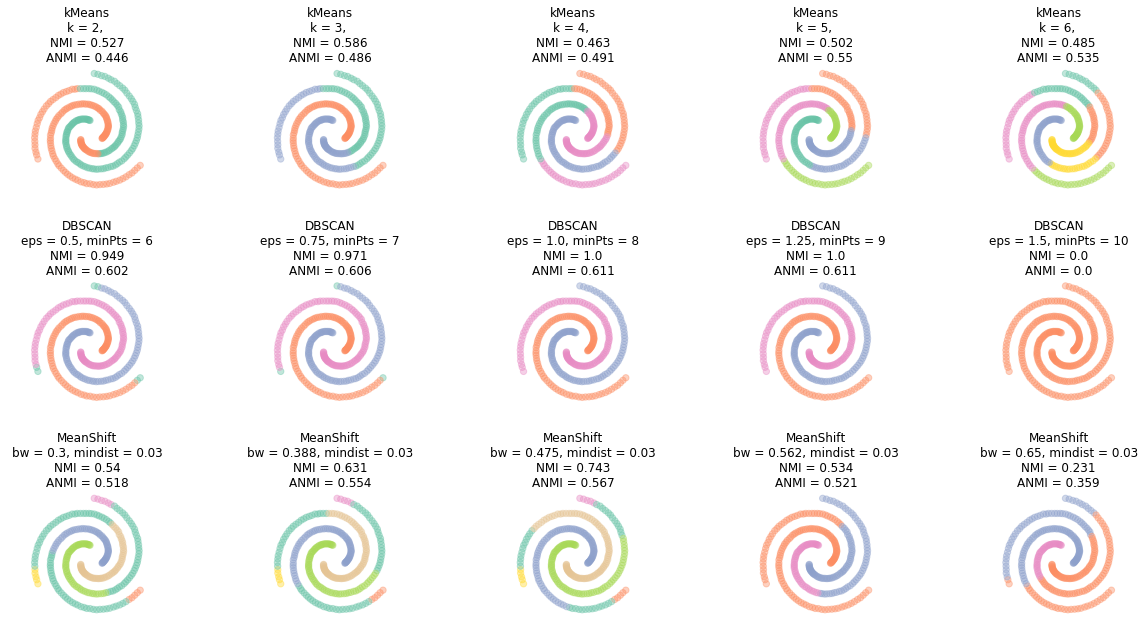

In [47]:
# Init plotting arrangement
num_plots = num_objects2
num_subplts_per_row = 5
num_rows = num_plots // num_subplts_per_row
num_cols = min(num_subplts_per_row, num_plots)
f, axarr = plt.subplots(num_rows,num_cols, figsize=(17, 3*num_rows))

# Plot labels
for i, ax in enumerate(axarr.flat):
    cur_x = i % num_subplts_per_row
    cur_y = i // num_subplts_per_row #-1
    ax.set_aspect('equal')
    ax.scatter(data[:, 0], data[:, 1], s=40, c=plt.cm.Set2(labels[i].astype(int)), alpha=0.4)
    ax.axis('off')
    if cur_y == 0:
        ax.set_title('kMeans\nk = {:}, \nNMI = {:.3}\nANMI = {:.3}'.format(k_arr[i], nmi_arr[i], anmi_vector[i]))
    elif cur_y == 1:
        ax.set_title('DBSCAN\neps = {:.3}, minPts = {:}\nNMI = {:.3}\nANMI = {:.3}'.format(eps_array[cur_x], minPts_array[cur_x], nmi_arr[i], anmi_vector[i]))
    elif cur_y == 2:
        ax.set_title('MeanShift\nbw = {:.3}, mindist = {:}\nNMI = {:.3}\nANMI = {:.3}'.format(bandwidthms_array[cur_x], mindist, nmi_arr[i], anmi_vector[i]))
plt.tight_layout()
plt.savefig('img/spiral_algs_all.pdf', transparent = True)
plt.savefig('img/spiral_algs_all.png', transparent = True)
plt.show()

In [48]:
print("The best algorithm choice (given the chosen range) has NMI ", np.max(nmi_arr), " compared to the consensus result")

The best algorithm choice (given the chosen range) has NMI  1.0  compared to the consensus result


In [49]:
#highest NMI with consensus
#best=np.argmax(nmi_arr)

#obj=clusterings[best]
#labels_alg_search=consensus_obj._noise_to_zero(obj).cluster_labels

#plot_synth_cons_par(data,consensus_obj.cluster_labels.astype(int),labels_alg_search,figsize = (10,5),savetitle = 'img/spiral_consensus.pdf')
#plot_synth_cons_par(data,consensus_obj.cluster_labels.astype(int),labels_alg_search.astype(int), figsize = (10,5),savetitle_cons = 'img/spiral_algs_consensus', savetitle_par = 'img/spiral_algs_NMI')

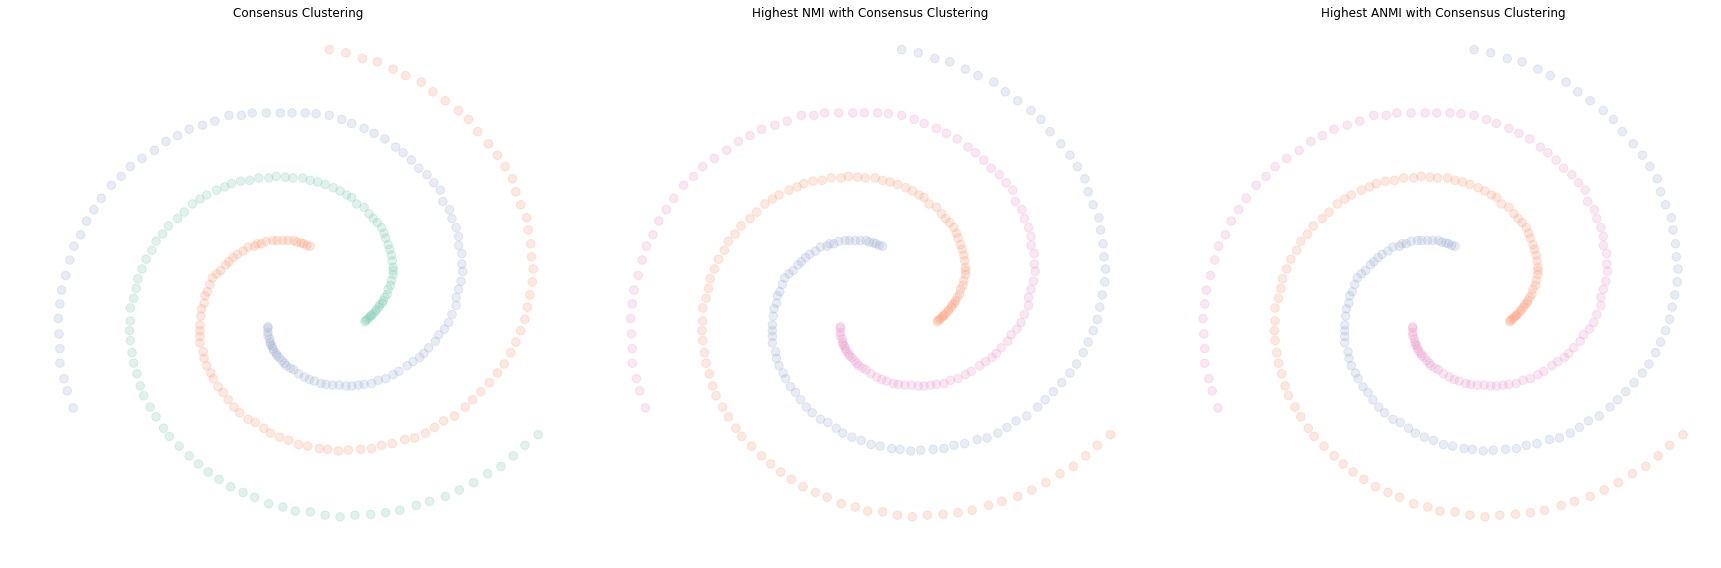

In [50]:
labels_nmi_best = np.array(clusterings[np.argmax(nmi_arr)].cluster_labels).astype(int)
labels_anmi_best = np.array(clusterings[np.argmax(anmi_vector)].cluster_labels).astype(int)

plot_synth_cons_par(data, 
                        consensus_obj.cluster_labels.astype(int), labels_nmi_best, labels_anmi_best, 
                        figsize = (24,8), savetitle_cons='img/spiral_algs_consensus', savetitle_nmi='img/spiral_algs_NMI', savetitle_anmi='img/spiral_algs_ANMI')